In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
input_length = 168
output_length = 24

show_graph = True

In [3]:
# Group 2

model_paths = ["Save_File/Grouped2_model_0602/A1.ckpt"]

building_num = [4]

data_path = "./Refined_Data/Grouped_Data/Input_Data2.csv"

In [4]:
dataframes = pd.read_csv(data_path, parse_dates = ["date_time"])

dataframes['num']     =   dataframes['num'].apply(str)
dataframes['Week']    =   dataframes['Week'].apply(str)
dataframes['24Hour']  =   dataframes['24Hour'].apply(str)
dataframes['holiday'] =   dataframes['holiday'].apply(str)
dataframes['Weekend'] =   dataframes['Weekend'].apply(str)
dataframes['energy_group'] = dataframes['energy_group'].apply(str)

random_choice = random.randrange(2,13)

start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

all_smape = []

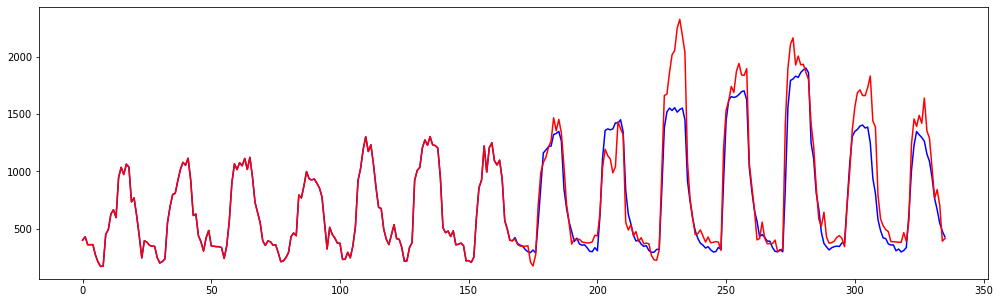

building : 4, score : 15.184908637946412


In [5]:
for i in range(len(model_paths)):
    now_building_dataframe = dataframes.loc[dataframes["num"] == str(building_num[i])].copy()
    now_building_dataframe = now_building_dataframe[start_point:start_point+input_length+duration]
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    original = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()
    prediction = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()  

    total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

    for k in range(total_cycle):
        now_start_point = k*output_length

        encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
        decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
        new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

        raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
        originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

        prediction.extend(raw_predictions)
        original.extend(originals)

        # for next step, change dataframe's original value to predicted value
        for p in range(output_length):
            now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
        
    if show_graph:
        plt.rcParams["figure.figsize"] = (17,5)
        fig = plt.figure()
        graph = fig.add_subplot(1, 1, 1)
        graph.plot(prediction, color='blue')
        graph.plot(original, color='red')
        plt.show()

    smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
    print(f"building : {building_num[i]}, score : {smape_loss}")
    all_smape.append(smape_loss)

In [6]:
print(f"selected time slice : {random_choice}")
print(f"totoal score : {np.mean(np.array(all_smape))}")

selected time slice : 10
totoal score : 15.184908637946412
